In [ ]:
"""
日本語URL
https://qiskit.org/textbook/ja/ch-algorithms/simon.html

英語URL
https://qiskit.org/textbook/ch-algorithms/simon.html
"""

In [ ]:
"""サイモンのアルゴリズム
サイモンのアルゴリズムは、古典的なアルゴリズムに比べて指数関数的な高速化を実現した最初の量子アルゴリズム。
このアルゴリズムに触発され、量子フーリエ変換（離散フーリエ変換の量子版）が生まれた。

【サイモンの問題】
与えられたブラックボックス関数fが「1対1対応関数」なのか「2対1対応関数」なのか判定する問題

さらに、fが「2対1対応関数」の場合、『特定の』秘密のビット列bを特定したい。

【古典的な解法】
n: 秘密のビット列bのビット数

fを最大で2^{n-1}+1回呼び出す必要がある。
なぜなら、同じ出力値に対して2つの入力値を見つかる可能性が、すべての入力値の半分を確認するまであるかもしれないから。
運が良ければ2回の呼び出しで2対1対応関数だとわかる場合がある。
このへんはドイチュ・ジョサと同じ考え。

【量子的な解法】
1. 2つのn量子ビットの入力レジスタを0に初期化する
2. 1つ目のレジスタにアダマールを適用する
3. クエリ関数Qfを適用する
4. 2つ目のレジスタを測定する。ある値f(x)が測定されたとする。この問題の性質上、測定値f(x)は2つの入力xと y=x⊕bに対応している。
5. 1つ目のレジスタにアダマールを適用する
6. 1つ目のレジスタを測定
何度か測定する必要がある

【排他的論理和の性質】
x ⊕ a = y <=> x ⊕ y = a
"""

In [4]:
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle
from qiskit.tools.monitor import job_monitor

<ipython-input-2-87ff53a5a143>:13: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  simon_circuit += simon_oracle(b)
c:\Users\takey\Desktop\myspace\workspace\my-practice\qiskit_textbook_practice\venv\lib\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


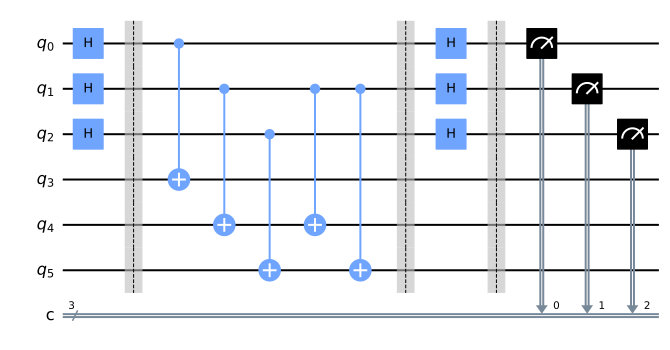

In [2]:
"""サイモンの回路実装
"""
b = "110"
n = len(b)

simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard
simon_circuit.h(range(n))
simon_circuit.barrier()

# Append simon-oracle
simon_circuit += simon_oracle(b)
simon_circuit.barrier()

# Re-apply Hadamard
simon_circuit.h(range(n))
simon_circuit.barrier()

# Measurement
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()

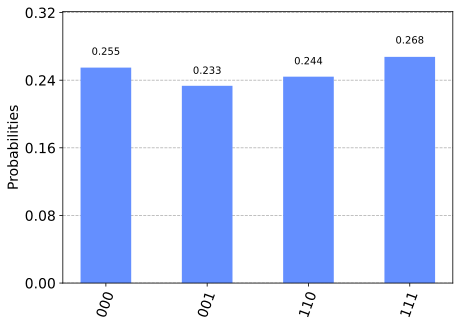

In [3]:
"""シミュレータで実行
"""
backend = Aer.get_backend("aer_simulator")
shots = 1024
results = backend.run(simon_circuit, shots=shots).result()
counts = results.get_counts()

plot_histogram(counts)

In [4]:
"""zの結果として、4種類の結果が測定された。
このあと、以下のようにヒット列 b="110" をこのzで検証すれば、4種類すべてでb*z = 0(mod 2)が成り立つことがわかる
"""
def bdotz(b, z):
    """zの出力とのドット内積を計算し検証する
    """ 
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum%2)

for z in counts:
    print("bdotz({}, {}) = {} (mod 2)".format(b, z, bdotz(b,z)))


bdotz(110, 000) = 0 (mod 2)
bdotz(110, 001) = 0 (mod 2)
bdotz(110, 111) = 0 (mod 2)
bdotz(110, 110) = 0 (mod 2)


In [8]:
"""
この得られた4種類のzを用いて、連立方程式を解けば、b=110を求めることができる

連立方程式はガウスの消去法で解ける（O(n^3)）
https://mathworld.wolfram.com/GaussianElimination.html
"""

b : 010


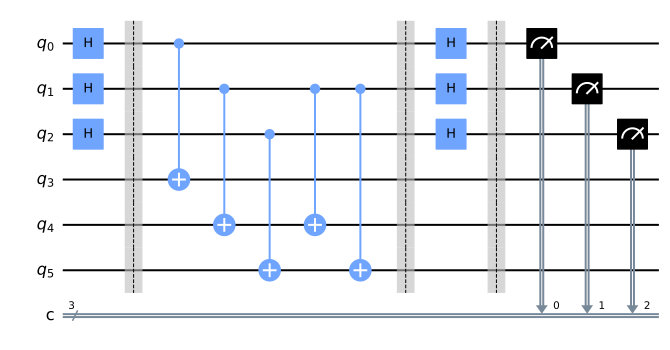

In [17]:
"""実機上での実行
現在、IBMQは5量子ビットしか持っていないので、b=11（2n=4）で実行する
"""
device_b = "11"
n = len(b)

simon_circuit2 = QuantumCircuit(n*2, n)

# 入力レジスタにアダマールを適用
simon_circuit2.h(range(n))
simon_circuit2.barrier()

# オラクルを追加
simon_circuit2 += simon_oracle(b)
simon_circuit2.barrier()

# 入力レジスタにアダマールを再度適用
simon_circuit2.h(range(n))
simon_circuit2.barrier()

# 測定する
simon_circuit2.measure(range(n), range(n))

simon_circuit2.draw()

In [12]:
# IBMQ.save_account("MY_TOKEN")
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q")
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_lima


In [14]:
# ジョブを実行し監視する
shots = 1024
transpiled_simon_circuit = transpile(simon_circuit2, backend, optimization_level=3)
qobj = assemble(transpiled_simon_circuit, shots=shots)
job = backend.run(qobj)
job_monitor(job, interval=2)

<ipython-input-14-82230417d27e>:5: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)
Job Status: job has successfully run


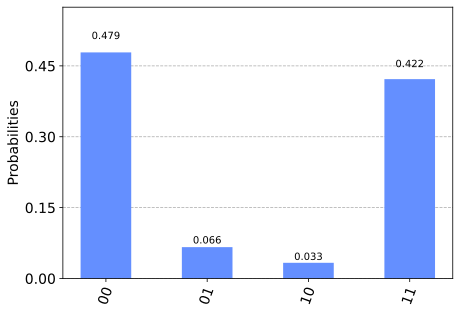

In [15]:
# 結果を取得する
device_count = job.result().get_counts()
plot_histogram(device_count)

In [19]:
# ドット内積を計算し検証する
print("b = ", device_b)

for z in device_count:
    print("bdotz({}, {}) = {} (mod 2) ({:.1f}%)".format(device_b, z, bdotz(device_b, z), device_count[z]*100/shots))

b =  11
bdotz(11, 00) = 0 (mod 2) (47.9%)
bdotz(11, 01) = 1 (mod 2) (6.6%)
bdotz(11, 10) = 1 (mod 2) (3.3%)
bdotz(11, 11) = 0 (mod 2) (42.2%)


In [9]:
"""
確率の低い01,10はノイズとして捨ててしまってよい。
00,11の2つの連立方程式を解くと、bを求めることができる
"""

'\n確率の低い01,10はノイズとして捨ててしまってよい。\n00,11の2つの連立方程式を解くと、bを求めることができる\n'

# 4. 量子オラクル

In [ ]:
"""
サイモンのアルゴリズムは、特定の秘密ビット列に特化している。このアルゴリズムを任意の秘密ビット列に対応するように拡張するには、問い合わせ関数についてより詳細に考察する必要がある。
"""

# 5. 演習

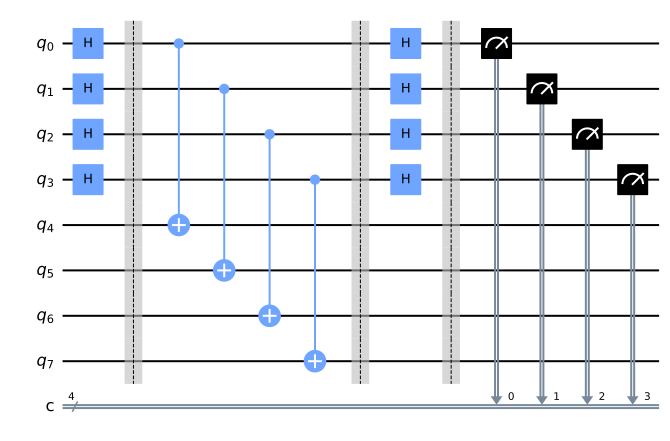

In [5]:
"""
一般的のサイモンの量子オラクルを作成して、
b = "1001"をテストする
"""
b = "1001"
n = len(b)

def make_simon_oracle():
    """一般のサイモンの量子オラクルを作成する
    """
    # 1個目のレジスタの内容を2個目のレジスタにコピーする
    return 0

simon_qc = QuantumCircuit(n*2, n)

# Apply Hadamard
simon_qc.h(range(n))
simon_qc.barrier()

# ここからサイモンオラクル
# 1. 1個目のレジスタの内容を2個目のレジスタにコピーする
# CNOTをすると、0のときは0を、1のときは1になるので実質コピー
for i in range(n):
    simon_qc.cx(i, i+n)
simon_qc.barrier()

"""[1対1または2対1写像を作る]
もしbが0でない場合、jビット目の値がbj=1となる最も小さなインデックスjが存在する。
もしxj=0ならば、2個目のレジスタにbに関してxorを適用する。そうでなければ、何もしない
"""


# Re-apply Hadamard
simon_qc.h(range(n))
simon_qc.barrier()

# Measurement
simon_qc.measure(range(n), range(n))
simon_qc.draw()
